In [1]:
%load_ext autoreload
%autoreload 2
import site
site.addsitedir('../')


Load the image as a

In [2]:
import twtof
filename = "/home/jeromeb/work/userdata/Bharat/TOFWERK HD5/20230722_magnetotactic_HO027_1_Au_pos_spot2_run1_30kV_50pA.h5"
fib, mass, peak = twtof.imread(filename)


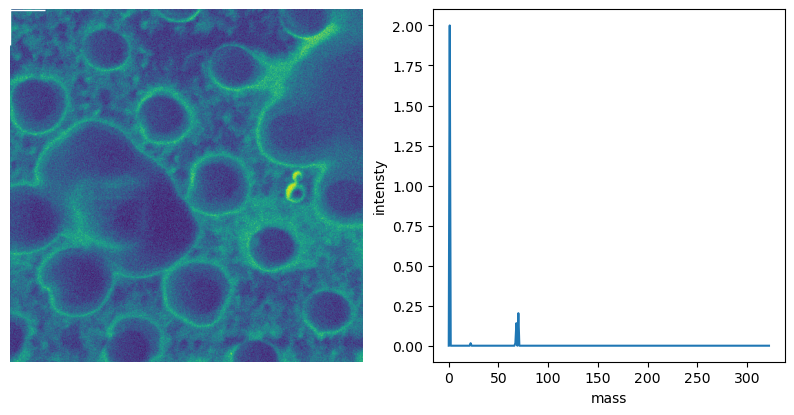

interactive(children=(IntSlider(value=255, description='x', max=511), IntSlider(value=255, description='y', ma…

In [3]:
from ipywidgets import interact
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(10,5))
axfib = ax[0].imshow(fib[0].squeeze())
crosshair = ax[0].plot(0,0,'w+',ms=50)
axpeak = ax[1].plot(peak[0,0,0].ravel())
ax[1].set(xlabel='mass', ylabel='intensty')
ax[1].set_box_aspect(1)
ax[0].set_axis_off()
@interact(
        x = (0,fib.shape[2]-1, 1), 
        y = (0,fib.shape[1]-1, 1), 
        z = (0, fib.shape[0]-1, 1), 
        cmap = ['viridis','jet','gray'])
def display(x,y,z,cmap):
    axfib.set(data = fib[z], cmap=cmap)
    crosshair[0].set(data=([x],[y]))
    ax[0].set_title(f'position {x},{y},{z}')
    d = int(fib.shape[1]/peak.shape[1])    
    axpeak[0].set(data = (mass, peak[z,y//d,x//d].ravel()))
    

Load the peak table

In [4]:
with twtof.TofH5Reader(filename) as f:
    peak_df = f.load_peak_table()
peak_df

,label,mass,lower integration limit,upper integration limit
0,nominal,1.0,0.5,1.5
1,nominal,2.0,1.5,2.5
2,nominal,3.0,2.5,3.5
3,nominal,4.0,3.5,4.5
4,nominal,5.0,4.5,5.5
...,...,...,...,...
318,nominal,319.0,318.5,319.5
319,nominal,320.0,319.5,320.5
320,nominal,321.0,320.5,321.5
321,nominal,322.0,321.5,322.5


Load all the data in a dictionnary

In [6]:
twtof.as_dict(filename)

{'Acquisition log':                   timestamp                                            message
 0 2023-07-22 16:04:00+01:00                                Acquisition started
 1 2023-07-22 16:05:54+01:00  Acquisition aborted after 32 complete writes. ...,
 'FIB image': array([[[23554., 22861., 26461., ..., 20923., 27392., 22112.],
         [20545., 24634., 19969., ..., 26429., 21707., 21530.],
         [25233., 19610., 26124., ..., 24263., 26949., 15016.],
         ...,
         [23436., 22914., 29689., ..., 39268., 38721., 39880.],
         [22408., 29822., 27445., ..., 35805., 39132., 40440.],
         [22574., 33563., 28405., ..., 35591., 40089., 39654.]],
 
        [[16471., 26974., 22822., ..., 23050., 20485., 26463.],
         [20372., 20413., 29319., ..., 22248., 24170., 23034.],
         [21547., 18473., 25700., ..., 26761., 22728., 23914.],
         ...,
         [30152., 31924., 35225., ..., 26153., 31172., 40807.],
         [25160., 35572., 31727., ..., 35229., 34856., 3